# EDA 
**How to use**
1. Open this file in Jupyter / JupyterLab / Colab.  
2. Run cells *top to bottom* (Kernel: Python 3.10+ recommended).  
3. When running data fetch cells you'll need internet for `yfinance`; if offline, use the backup CSV path provided in the CONFIG cell.

In [23]:
# 1. Setup & Imports
import os                               # File system operations
import pandas as pd                     # Data handling
import numpy as np                      # Numerical operations
import matplotlib.pyplot as plt         # Plotting
import seaborn as sns                   # Advanced visualization
import yfinance as yf                   # Fetch stock data
import pandas_market_calendars as mcal  # Market trading calendar
from datetime import datetime
from scipy import stats                 # Z-score / statistical functions
import plotly.graph_objects as go
import plotly.express as px
import warnings
warnings.filterwarnings("ignore")
from config import CONFIG

# Display & Plotting settings
pd.set_option("display.max_columns", None)
plt.style.use("seaborn-v0_8")

# display inline (Jupyter)
%matplotlib inline

print("Packages imported. Matplotlib inline ready.")

Packages imported. Matplotlib inline ready.


## 2) Configuration
Edit `CONFIG` below for tickers, date range, and file paths. For presentations it's convenient to keep defaults,
but you can change tickers or dates interactively.


In [24]:
# 2) Configuration (edit if needed)
CONFIG = {
    "tickers": ["AAPL", "MSFT", "GOOGL", "JPM", "TSLA"],
    "start_date": "2022-01-01",
    "end_date": "2025-01-01",
    "backup_path": "data/backup_stocks.csv",
    "output_long": "data/cleaned_stock_data_long.csv",
    "output_wide": "data/cleaned_stock_data_wide.csv",
}
CONFIG

{'tickers': ['AAPL', 'MSFT', 'GOOGL', 'JPM', 'TSLA'],
 'start_date': '2022-01-01',
 'end_date': '2025-01-01',
 'backup_path': 'data/backup_stocks.csv',
 'output_long': 'data/cleaned_stock_data_long.csv',
 'output_wide': 'data/cleaned_stock_data_wide.csv'}

## 3) Data Acquisition
This cell defines `fetch_stock_data()` which uses `yfinance` and falls back to a CSV if `yfinance` fails.
Run the cell to fetch data (or, if offline, ensure backup CSV exists).

In [25]:
def fetch_stock_data(tickers, start, end, backup_path):
    """Fetch historical stock data from yfinance (multi-ticker) with CSV fallback."""
    try:
        # Validate input
        if not tickers:
            raise ValueError("No tickers provided")

        # Attempt to fetch from yfinance
        data = yf.download(
            tickers,
            start=start,
            end=end,
            group_by="ticker",
            auto_adjust=True,
            progress=False
        )

        if data.empty:
            raise ValueError("Empty response from yfinance")

        print(f"Data fetched for {len(tickers) if isinstance(tickers, list) else 1} "
              f"ticker(s): {start} → {end}")
        return data

    except Exception as e:
        # Fallback to backup CSV if API call fails
        print(f"yfinance failed: {e}. Loading backup CSV: {backup_path}")
        return pd.read_csv(backup_path, parse_dates=['Date'])


# Example usage (uncomment to run in notebook)
raw_data = fetch_stock_data(CONFIG['tickers'], CONFIG['start_date'], CONFIG['end_date'], CONFIG['backup_path'])
raw_data.head()

Data fetched for 5 ticker(s): 2022-01-01 → 2025-01-01


Ticker             JPM                                                \
Price             Open        High         Low       Close    Volume   
Date                                                                   
2022-01-03  143.926634  146.429548  143.611513  145.583237  13120900   
2022-01-04  147.933087  151.777496  147.861059  151.102249  20195800   
2022-01-05  151.998954  152.488040  148.294524  148.339813  17539400   
2022-01-06  151.174684  151.591310  148.421270  149.915726  14047500   
2022-01-07  150.051632  151.736283  149.499139  151.401169  13913300   

Ticker           GOOGL                                                \
Price             Open        High         Low       Close    Volume   
Date                                                                   
2022-01-03  144.061394  144.851946  142.728591  143.998337  28646000   
2022-01-04  144.400050  145.481595  142.732065  143.410385  28400000   
2022-01-05  143.430756  143.509710  136.744874  136.831268  54618000   
2022-01-06  136.060077  138.981426  135.623089  136.803940  37348000   
2022-01-07  137.199225  137.500158  134.836523  136.078461  29760000   

Ticker            MSFT                                                \
Price             Open        High         Low       Close    Volume   
Date                                                                   
2022-01-03  325.086281  327.655169  319.686749  324.504639  28865100   
2022-01-04  324.582127  324.940827  316.138715  318.940277  32674300   
2022-01-05  315.886673  316.090267  306.309087  306.696838  40054300   
2022-01-06  303.565678  308.945831  301.956480  304.273346  39646100   
2022-01-07  304.535055  306.813137  300.599319  304.428436  32720000   

Ticker            AAPL                                                 \
Price             Open        High         Low       Close     Volume   
Date                                                                    
2022-01-03  174.345053  179.296091  174.227410  178.443130  104487900   
2022-01-04  179.050963  179.354886  175.609740  176.178375   99310400   
2022-01-05  176.090157  176.639180  171.217554  171.492065   94537600   
2022-01-06  169.315582  171.864636  168.276357  168.629303   96904000   
2022-01-07  169.501866  170.727370  167.678316  168.795975   86709100   

Ticker            TSLA                                                 
Price             Open        High         Low       Close     Volume  
Date                                                                   
2022-01-03  382.583344  400.356659  378.679993  399.926666  103931400  
2022-01-04  396.516663  402.666656  374.350006  383.196655  100248300  
2022-01-05  382.216675  390.113342  360.336670  362.706665   80119800  
2022-01-06  359.000000  362.666656  340.166656  354.899994   90336600  
2022-01-07  360.123322  360.309998  336.666656  342.320007   84164700

## 4) Cleaning functions
Contains `clean_stock_data()` and `clean_all_tickers()` — robust cleaning, normalize dates, handle missing values, enforce numeric types.


In [59]:
# 4. Data Cleaning
def clean_stock_data(df: pd.DataFrame, ticker: str) -> pd.DataFrame:
    """
    Clean stock data for a single ticker.
    
    Steps:
        - Ensure required columns are present
        - Normalize and sort by date
        - Handle missing values (drop if >50%, else forward/backward fill)
        - Drop duplicates and enforce numeric dtypes
        - Validate constraints (non-negative prices, volumes and valid dates)
    """
    df = df.copy().reset_index()
    df["Ticker"] = ticker

    # Validate inputs and check required columns
    required_cols = ["Date", "Open", "High", "Low", "Close", "Volume"]
    for col in required_cols:
        if col not in df.columns:
            raise ValueError(f"Missing required column '{col}' for {ticker}")

    if df.empty:
        raise ValueError(f"No data available for {ticker}")

    # Normalize and sort dates
    df["Date"] = pd.to_datetime(df["Date"]).dt.normalize()
    df.sort_values("Date", inplace=True)

    # Handle missing values (drop if >50% columns missing, else fill)
    core_cols = ["Open", "High", "Low", "Close", "Volume"]
    missing_pct = df[core_cols].isnull().mean(axis=1)
    df = df[missing_pct < 0.5] # Drop rows with excessive missing values

    # Fill remaining missing values using forward/backward fill
    df = df.ffill().bfill() 

    # Drop duplicate dates
    df.drop_duplicates(subset=["Date"], inplace=True)

    # Ensure numeric types
    for col in core_cols:
        df[col] = pd.to_numeric(df[col], errors="coerce")

    # Validation: no negative values
    if (df[["Open", "High", "Low", "Close"]] < 0).any().any():
        raise ValueError(f"Negative prices detected for {ticker}")
    if (df["Volume"] < 0).any():
        raise ValueError(f"Negative volumes detected for {ticker}")

    # Reset index after cleaning
    df.reset_index(drop=True, inplace=True)

    return df


In [60]:
def clean_all_tickers(raw_data: pd.DataFrame, tickers: list[str]) -> pd.DataFrame:
    """
    Clean stock data for multiple tickers and combine into a single DataFrame.
    """
    cleaned_list = []

    for t in tickers:
        try:
            temp = raw_data[t].reset_index()
            cleaned = clean_stock_data(temp, t)
            cleaned_list.append(cleaned)
            print(f"{t} cleaned successfully ({len(cleaned)} rows).")
        except Exception as e:
            print(f"Error processing {t}: {e}")

    combined = pd.concat(cleaned_list, ignore_index=True)

    # Drop extra 'index' column if present
    if "index" in combined.columns:
        combined.drop(columns=["index"], inplace=True)

    return combined

In [61]:
# Example usage (uncomment to run after fetching data)
cleaned_data = clean_all_tickers(raw_data, CONFIG["tickers"])
print(f"Final cleaned dataset shape: {cleaned_data.shape}")
cleaned_data.head()

AAPL cleaned successfully (753 rows).
MSFT cleaned successfully (753 rows).
GOOGL cleaned successfully (753 rows).
JPM cleaned successfully (753 rows).
TSLA cleaned successfully (753 rows).
Final cleaned dataset shape: (3765, 7)


Price,Date,Open,High,Low,Close,Volume,Ticker
0,2022-01-03,174.345053,179.296091,174.227410,178.443130,104487900,AAPL
1,2022-01-04,179.050963,179.354886,175.609740,176.178375,99310400,AAPL
2,2022-01-05,176.090157,176.639180,171.217554,171.492065,94537600,AAPL
3,2022-01-06,169.315582,171.864636,168.276357,168.629303,96904000,AAPL
4,2022-01-07,169.501866,170.727370,167.678316,168.795975,86709100,AAPL


## 5) Trading day alignment & Outlier detection
Align data with NYSE trading calendar and detect outliers using Z-score and IQR.


In [27]:
def align_with_trading_days(df: pd.DataFrame, start: str, end: str) -> pd.DataFrame:
    """
    Align stock data with official NYSE trading days.
    """
    nyse = mcal.get_calendar("NYSE")
    schedule = nyse.schedule(start_date=start, end_date=end)
    trading_days = schedule.index.normalize()

    df = df.copy()
    df["Date"] = pd.to_datetime(df["Date"]).dt.normalize()
    df = df[df["Date"].isin(trading_days)]

    print(f"Data aligned with NYSE trading days "
          f"({trading_days.min().date()} → {trading_days.max().date()})")
    return df


# Example usage (after cleaning):
cleaned_data = align_with_trading_days(cleaned_data, CONFIG['start_date'], CONFIG['end_date'])


Data aligned with NYSE trading days (2022-01-03 → 2024-12-31)


In [28]:
def detect_outliers(df: pd.DataFrame) -> pd.DataFrame:
    """
    Detect outliers in daily returns using Z-score and IQR.
    
    Adds:
        - Daily_Return
        - Z_Score
        - Outlier_Z
        - Outlier_IQR
    """
    df = df.copy()
    
    # Daily returns
    df["Daily_Return"] = df.groupby("Ticker")["Close"].pct_change()

    # Z-score method
    df["Z_Score"] = df.groupby("Ticker")["Daily_Return"].transform(
        lambda x: stats.zscore(x, nan_policy="omit")
    )
    df["Outlier_Z"] = df["Z_Score"].abs() > 3

    # IQR method
    def iqr_outliers(series):
        q1, q3 = np.nanpercentile(series, [25, 75])
        iqr = q3 - q1
        return (series < (q1 - 1.5 * iqr)) | (series > (q3 + 1.5 * iqr))

    df["Outlier_IQR"] = df.groupby("Ticker")["Daily_Return"].transform(iqr_outliers)

    print("Outlier detection completed (Z-score & IQR).")
    return df

# Example usage (after cleaning):
cleaned_data = detect_outliers(cleaned_data)
cleaned_data.head()

Outlier detection completed (Z-score & IQR).


Price,Date,Open,High,Low,Close,Volume,Ticker,Daily_Return,Z_Score,Outlier_Z,Outlier_IQR
0,2022-01-03,174.345053,179.296091,174.227410,178.443130,104487900,AAPL,NaN,NaN,False,False
1,2022-01-04,179.050963,179.354886,175.609740,176.178375,99310400,AAPL,-0.012692,-0.778782,False,False
2,2022-01-05,176.090157,176.639180,171.217554,171.492065,94537600,AAPL,-0.026600,-1.594219,False,False
3,2022-01-06,169.315582,171.864636,168.276357,168.629303,96904000,AAPL,-0.016693,-1.013393,False,False
4,2022-01-07,169.501866,170.727370,167.678316,168.795975,86709100,AAPL,0.000988,0.023292,False,False


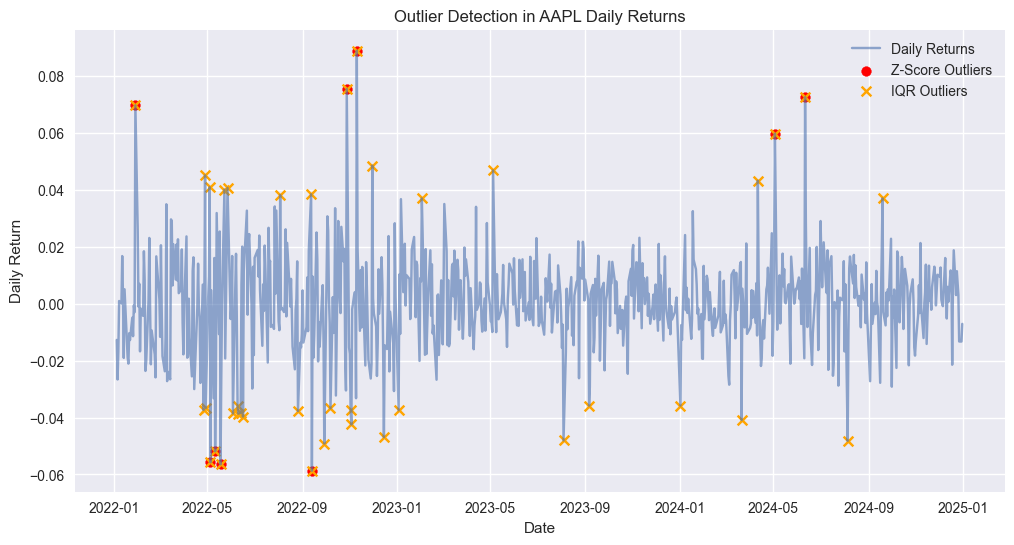

In [29]:
def plot_outliers(df: pd.DataFrame, tickers: list[str] | str):
    """
    Plot daily returns and highlight outliers for one or more tickers.
    """
    if isinstance(tickers, str):
        tickers = [tickers]

    for ticker in tickers:
        subset = df[df["Ticker"] == ticker]
        plt.figure(figsize=(12, 6))
        plt.plot(subset["Date"], subset["Daily_Return"], label="Daily Returns", alpha=0.6)
        plt.scatter(subset["Date"][subset["Outlier_Z"]],
                    subset["Daily_Return"][subset["Outlier_Z"]],
                    color="red", label="Z-Score Outliers")
        plt.scatter(subset["Date"][subset["Outlier_IQR"]],
                    subset["Daily_Return"][subset["Outlier_IQR"]],
                    color="orange", marker="x", label="IQR Outliers")

        plt.title(f"Outlier Detection in {ticker} Daily Returns")
        plt.xlabel("Date")
        plt.ylabel("Daily Return")
        plt.legend()
        plt.show()

# Example: Plot for all tickers in a loop
plot_outliers(cleaned_data, ["AAPL"]) 
# plot_outliers(cleaned_data, ["AAPL", "JPM"])  # Tech & Finance examples

## 6) Data quality report & validation
A short per-ticker report and automated validation tests.


In [30]:
# 6. Data Quality & Validation

def data_quality_report(df: pd.DataFrame) -> pd.DataFrame:
    """
    Generate a data quality report per ticker including:
        - Row count
        - Date range
        - Missing values %
        - Duplicate dates
        - Coverage of expected NYSE trading days
    """
    core_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
    report = []
    nyse = mcal.get_calendar('NYSE')  # NYSE trading calendar

    # Group by ticker and calculate metrics
    for ticker, group in df.groupby('Ticker'):
        total_rows = len(group)
        
        # Missing values %
        missing_pct = (group[core_cols].isnull().sum().sum() / (total_rows * len(core_cols))) * 100
        
        # Duplicate date count
        duplicates = group.duplicated(subset=['Date']).sum()
        
        # Date range
        min_date, max_date = group['Date'].min(), group['Date'].max()
        
        # Trading days coverage
        schedule = nyse.schedule(start_date=min_date, end_date=max_date)
        expected_days = len(schedule)
        coverage_pct = (total_rows / expected_days) * 100 if expected_days > 0 else np.nan
        
        # Append metrics to report
        report.append({
            'Ticker': ticker,
            'Rows': total_rows,
            'Date Range': f'{min_date.date()} → {max_date.date()}',
            'Missing %': f'{missing_pct:.2f}%',
            'Duplicates': duplicates,
            'Coverage %': f'{coverage_pct:.2f}%'
        })
    
    return pd.DataFrame(report)

# Example usage (after cleaning and outlier detection)
report = data_quality_report(cleaned_data)
print("Data Quality Report")
display(report)  # Display summary table

Data Quality Report


,Ticker,Rows,Date Range,Missing %,Duplicates,Coverage %
0,AAPL,753,2022-01-03 → 2024-12-31,0.00%,0,100.00%
1,GOOGL,753,2022-01-03 → 2024-12-31,0.00%,0,100.00%
2,JPM,753,2022-01-03 → 2024-12-31,0.00%,0,100.00%
3,MSFT,753,2022-01-03 → 2024-12-31,0.00%,0,100.00%
4,TSLA,753,2022-01-03 → 2024-12-31,0.00%,0,100.00%


In [31]:
# 9. Validation Tests
def validate_preprocessing(df: pd.DataFrame, start_date: str, end_date: str):
    """
    Perform automated checks to ensure preprocessing correctness:
        1. No missing core values
        2. Daily returns computed correctly
        3. Non-negative prices
        4. No duplicate dates
        5. Date ranges within bounds
    """
    # 1. Missing values
    assert df[["Open", "High", "Low", "Close", "Volume"]].isnull().sum().sum() == 0, \
        "Missing values remain!"

    # 2. Daily returns consistency
    for ticker in df["Ticker"].unique():
        subset = df[df["Ticker"] == ticker]
        expected_returns = subset["Close"].pct_change()
        assert np.allclose(subset["Daily_Return"].dropna(), expected_returns.dropna(), equal_nan=True), \
            f"Daily returns mismatch for {ticker}"

    # 3. Non-negative prices
    assert (df[["Open", "High", "Low", "Close"]] >= 0).all().all(), "Negative prices detected!"

    # 4. No duplicates
    for ticker, group in df.groupby("Ticker"):
        assert not group["Date"].duplicated().any(), f"Duplicates found in {ticker}"

    # 5. Date range validation
    for ticker, group in df.groupby("Ticker"):
        assert group['Date'].min() >= pd.to_datetime(start_date), f'Start date invalid for {ticker}'
        assert group['Date'].max() <= pd.to_datetime(end_date), f'End date invalid for {ticker}'

    print("Preprocessing validations passed!")


# Run validation checks
validate_preprocessing(cleaned_data, CONFIG['start_date'], CONFIG['end_date'])

Preprocessing validations passed!


## 7) Pivot to wide format & basic statistics
Create a pivot table of Close prices and compute mean/volatility/skew/kurtosis/sharpe.


In [32]:
def pivot_wide(df):
    pivot = df.pivot(index='Date', columns='Ticker', values='Close').ffill().bfill()
    return pivot

def compute_stats(pivot):
    daily_returns = pivot.pct_change().dropna()
    stats_df = pd.DataFrame({
        'Ticker': daily_returns.columns,
        'Mean Return': daily_returns.mean(),
        'Volatility (Std)': daily_returns.std(),
        'Min Return': daily_returns.min(),
        'Max Return': daily_returns.max(),
        'Skewness': daily_returns.skew(),
        'Kurtosis': daily_returns.kurtosis(),
        'Sharpe (approx)': daily_returns.mean()/daily_returns.std()
    }).reset_index(drop=True)
    return stats_df

# Example usage:
pivot = pivot_wide(cleaned_data)
stats_df = compute_stats(pivot)
stats_df

,Ticker,Mean Return,Volatility (Std),Min Return,Max Return,Skewness,Kurtosis,Sharpe (approx)
0,AAPL,0.000591,0.017067,-0.058680,0.088975,0.213381,2.514836,0.034635
1,GOOGL,0.000572,0.020627,-0.095094,0.102243,0.013493,2.727508,0.027731
2,JPM,0.000759,0.015743,-0.064678,0.115445,0.398059,5.741144,0.048196
3,MSFT,0.000491,0.017372,-0.077156,0.082268,0.009359,1.955815,0.028278
4,TSLA,0.000755,0.038618,-0.123346,0.219190,0.245814,2.193303,0.019547


## 8) Visualizations (presentation-ready)
Plot price series, SMAs, rolling volatility, correlation heatmap, boxplots, and outlier visualisations.
Each plot cell includes a short presenter note you can read aloud.


In [42]:
from src.graph import (plot_price_sma,plot_streaks,plot_profit_comparison,plot_annual_risk_return,plot_best_buy_sell)  # 
from src.profit import calculate_profits
from src.analytics import calculate_annual_risk_return

# 1) Prepare data
ticker = "AAPL"  # Change as needed
subset = cleaned_data[cleaned_data["Ticker"] == ticker].sort_values("Date").copy()

# Calculate Daily Returns if not already present
if "Daily_Return" not in cleaned_data.columns:
    cleaned_data["Daily_Return"] = cleaned_data.groupby("Ticker")["Close"].pct_change()

# Calculate Streaks if not already present
if "Streak" not in cleaned_data.columns:
    def compute_streaks(group):
        streak = []
        current_streak = 0
        for r in group["Daily_Return"].fillna(0):
            if r > 0:
                current_streak = current_streak + 1 if current_streak > 0 else 1
            elif r < 0:
                current_streak = current_streak - 1 if current_streak < 0 else -1
            else:
                current_streak = 0
            streak.append(current_streak)
        group["Streak"] = streak
        return group

    cleaned_data = cleaned_data.groupby("Ticker").apply(compute_streaks).reset_index(drop=True)


In [ ]:
# 2) SMA + Buy/Sell Crossovers
print(f"\n📈 SMA Price Chart + Crossovers for {ticker}")
sma_windows = [10]  # can add more
plot_price_sma(cleaned_data, ticker=ticker, sma_windows=sma_windows)

2025-10-09 03:18:48.218 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-09 03:18:48.218 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-09 03:18:48.218 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-09 03:18:48.222 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-09 03:18:48.223 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.



📈 SMA Price Chart + Crossovers for AAPL


In [ ]:
# 3) Buy / Sell Signal Graph
print(f"\n🟢🔴 Buy / Sell Points for {ticker}")
plot_best_buy_sell(cleaned_data, ticker=ticker)


2025-10-09 03:18:44.448 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-09 03:18:44.452 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-09 03:18:44.452 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-09 03:18:44.452 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-09 03:18:44.452 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.



🟢🔴 Buy / Sell Points for AAPL


In [ ]:
# 4) Streak Graph
print(f"\n📊 Streak Chart for {ticker}")
plot_streaks(cleaned_data, ticker=ticker)

2025-10-09 03:18:39.772 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-09 03:18:39.772 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-09 03:18:39.772 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-09 03:18:39.778 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-09 03:18:39.778 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.



📊 Streak Chart for AAPL


In [ ]:
# 5) Profit Comparison Graph
print(f"\n💰 Profit Comparison")
profits_df = calculate_profits(cleaned_data)
plot_profit_comparison(profits_df)

INFO:src.profit:AAPL → Buy: 2023-01-05 @ $123.28, Sell: 2024-12-26 @ $258.10, Profit: $134.82, Return: 109.36%, MultiTx: $835.20
INFO:src.profit:MSFT → Buy: 2022-11-03 @ $209.05, Sell: 2024-07-05 @ $463.24, Profit: $254.19, Return: 121.59%, MultiTx: $1558.00
INFO:src.profit:GOOGL → Buy: 2022-11-03 @ $82.86, Sell: 2024-12-16 @ $196.02, Profit: $113.16, Return: 136.57%, MultiTx: $750.83
INFO:src.profit:JPM → Buy: 2022-10-11 @ $94.69, Sell: 2024-11-25 @ $245.10, Profit: $150.41, Return: 158.83%, MultiTx: $656.23
INFO:src.profit:TSLA → Buy: 2023-01-03 @ $108.10, Sell: 2024-12-17 @ $479.86, Profit: $371.76, Return: 343.90%, MultiTx: $2552.41
INFO:src.profit:Profit optimization completed for all tickers.

2025-10-09 03:18:28.794 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-09 03:18:28.798 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-09 03:18:28.798 Thread 'MainThr


💰 Profit Comparison


In [ ]:
# 6) Risk vs Return Graph
print(f"\n📉 Risk vs Return")
risk_return_df = calculate_annual_risk_return(cleaned_data)
plot_annual_risk_return(risk_return_df)

INFO:src.analytics:Annual risk-return calculated.


2025-10-09 03:18:31.486 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-09 03:18:31.486 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-09 03:18:31.489 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-09 03:18:31.490 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-09 03:18:31.492 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.



📉 Risk vs Return


## 9) Save cleaned & pivot datasets
Choose to save your cleaned long-format and wide-format datasets to the `data/` folder so downstream modules can use them.


In [38]:
# Save (uncomment to write)
def save_outputs(cleaned_df, pivot_df, config):
    os.makedirs(os.path.dirname(config['output_long']), exist_ok=True)
    os.makedirs(os.path.dirname(config['output_wide']), exist_ok=True)
    
    # Save long-format dataset
    cleaned_df.to_csv(config['output_long'], index=False)
    print(f"Long-format dataset saved: {config['output_long']}")
    
    # Save wide-format dataset
    pivot_df.to_csv(config['output_wide'])
    print(f"Wide-format dataset saved: {config['output_wide']}")

# Example usage:
save_outputs(cleaned_data, pivot, CONFIG)


Long-format dataset saved: data/cleaned_stock_data_long.csv
Wide-format dataset saved: data/cleaned_stock_data_wide.csv


## 10) Presenter notes & suggested talking points
- Show the price series first and point out notable moves (dates).  
- Walk through SMA overlays to explain trend smoothing (mention window).  
- Use correlation heatmap to state which tickers move together.  
- Use boxplots & distribution plots to comment on skewness and fat tails.  
- Show outlier plots and explain methodology (Z-score vs IQR).  
- End with the data quality report (coverage %, missing %) to demonstrate robustness.
